In [2]:
from astropy import units as u
from itertools import product
from gwexpy.frequencyseries import *
from gwexpy.apparatus import *

* パッケージ名：gwexpy -> gwpyの拡張(expand)、特に実験(experiments)に便利な機能を追加　という意味で
    * gwexpy.frequencyseries.FrequencySeries
        * gwpy.frequencyseries.FrequencySeries を丸々継承
    * gwexpy.frequencyseries.FrequencySeriesDict
        * TimeSeriesDictのように、複数チャンネルのFrequencySeriesをまとめたクラス
        * .span, .crop(), .plot(), .resample(), .read(), .write() などを使えるように
        * TimeSeriesDictオブジェクト(例: tsd)から tsd.fft(), tsd.asd(fftlen, overlap) のように直接生成できると便利
    * gwexpy.frequencyseries.FrequencySeriesMatrix
        * 今議論している、周波数空間におけるNチャンネル×Mチャンネルの組み合わせ
        * 伝達関数、クロススペクトル密度、コヒーレンス、カップリングファンクションなどに使用する目的
        * 周波数軸は全成分で共通
        * N+Mチャンネル分のメタデータを保持(key, name, channel, unit)
        * 成分を指定してFrequencySeriesオブジェクトとして取得や代入できるように 
        * .span, .crop(), .plot(), .resample(), .read(), .write() などを使えるように
        * 周波数の各点ごとに、N×M行列の色々な計算(逆行列、対角化、エルミート共役など)ができると便利
        * TimeSeriesDictやFrequencySeriesDictのオブジェクトから直接生成できると便利
    * gwexpy.frequencyseries.RigidBodyTF
        * 先ほどまで議論していた、TF_6x6のこと。CamelCase命名規則に従いアンダーバーはやめる。
        * 'len','tra','var','rol','pit','yaw' の6自由度(並進3+回転3)の入出力で、合計36成分
        * ひとつの剛体内での自由度間カップリングでも、ふたつの剛体の各自由度間カップリングでもよい
        * 並進と回転の組み合わせ(4組)×強度と位相 で4列2行のbode plotを生成可能
    * gwexpy.apparatus
        * 重力波実験の装置に関するモジュール
        * 防振装置、光学装置、実験室、地形、地球上での位置など扱えるようにしたい
    * gwexpy.apparatus.Stage
        * 防振装置のとある1段
        * 名前、伝達関数行列("TF_6x6")、上段との間の変位ベクトル・回転ベクトル、質量、慣性モーメント
        * 物理量はastropyのquantitiyで、単位付きの量(スカラー、ベクトル、テンソル)として扱う
        * 伝達関数行列を自動計算する機能、直接入力する機能
    * gwexpy.apparatus.Suspension
        * Stageを縦に直列に連結した、1台の防振装置
        * 最初のindex(0) がテストマス鏡、最後のindex(-1)が地面とする
        * 名前、グローバル座標(X,Y,Z)におけるテストマス鏡の位置と方向(length, transvers,vartical)を定義
        * 各段に外力(時系列もしくは周波数スペクトル)を与えたときの運動を、伝達関数を用いて自動計算
        * 各段の伝達関数を組み合わせて防振装置全体のモード解析 (python-controls利用？)
    * gwexpy.apparatus.FPMI
        * Suspension 4台で構成される1組のファブリペロ干渉計
        * DARM (differencial arm length), CARM (common arm length), MICH (short michelson) などを時系列や周波数空間で計算したい
        * 将来的に、pykat(FINESS)やgtraceを組み込んだ光学シミュレーションもできると最高

In [3]:
Q = params_6x6([[100, 10, 10, 10, 10, 10],
                [ 10,100, 10, 10, 10, 10],
                [ 10, 10,100, 10, 10, 10],
                [ 10, 10, 10, 30, 10, 10],
                [ 10, 10, 10, 10, 30, 10],
                [ 10, 10, 10, 10, 10, 30]],
               u.Quantity(1))

f0 = params_6x6([[1.00, 0.10, 0.12, 0.04, 0.03, 0.02],
                 [0.10, 1.50, 0.11, 0.03, 0.04, 0.03],
                 [0.12, 0.13, 2.00, 0.02, 0.03, 0.04],
                 [0.04, 0.03, 0.02, 0.30, 0.02, 0.01],
                 [0.03, 0.04, 0.03, 0.02, 0.50, 0.02],
                 [0.02, 0.03, 0.04, 0.01, 0.02, 0.70]],
                u.Hz)

gain = params_6x6([[1.00, 0.01, 0.01, 0.10, 0.10, 0.10],
                   [0.01, 1.00, 0.01, 0.10, 0.10, 0.10],
                   [0.01, 0.01, 1.00, 0.02, 0.10, 0.10],
                   [0.10, 0.03, 0.10, 1.00, 0.01, 0.01],
                   [0.10, 0.10, 0.10, 0.01, 1.00, 0.01],
                   [0.10, 0.10, 0.10, 0.01, 0.01, 1.00]],
                  [[u.Quantity(1)]*3 + [u.rad/u.m]*3,
                   [u.Quantity(1)]*3 + [u.rad/u.m]*3,
                   [u.Quantity(1)]*3 + [u.rad/u.m]*3,
                   [u.m/u.rad]*3 + [u.Quantity(1)]*3, 
                   [u.m/u.rad]*3 + [u.Quantity(1)]*3, 
                   [u.m/u.rad]*3 + [u.Quantity(1)]*3])

In [5]:
print(Q)
print(f0)
print(gain)

<params_6x6: (6, 6) matrix, unit=1.0>
       len    tra    var   rol   pit   yaw
len  100.0   10.0   10.0  10.0  10.0  10.0
tra   10.0  100.0   10.0  10.0  10.0  10.0
var   10.0   10.0  100.0  10.0  10.0  10.0
rol   10.0   10.0   10.0  30.0  10.0  10.0
pit   10.0   10.0   10.0  10.0  30.0  10.0
yaw   10.0   10.0   10.0  10.0  10.0  30.0
<params_6x6: (6, 6) matrix, unit=Hz>
         len      tra      var      rol      pit      yaw
len   1.0 Hz   0.1 Hz  0.12 Hz  0.04 Hz  0.03 Hz  0.02 Hz
tra   0.1 Hz   1.5 Hz  0.11 Hz  0.03 Hz  0.04 Hz  0.03 Hz
var  0.12 Hz  0.13 Hz   2.0 Hz  0.02 Hz  0.03 Hz  0.04 Hz
rol  0.04 Hz  0.03 Hz  0.02 Hz   0.3 Hz  0.02 Hz  0.01 Hz
pit  0.03 Hz  0.04 Hz  0.03 Hz  0.02 Hz   0.5 Hz  0.02 Hz
yaw  0.02 Hz  0.03 Hz  0.04 Hz  0.01 Hz  0.02 Hz   0.7 Hz
<params_6x6: (6, 6) matrix, unit=various units>
             len           tra          var           rol          pit  \
len          1.0          0.01         0.01   0.1 rad / m  0.1 rad / m   
tra         0.01      

In [6]:
f0.to_pandas()

,len,tra,var,rol,pit,yaw
len,1.0 Hz,0.1 Hz,0.12 Hz,0.04 Hz,0.03 Hz,0.02 Hz
tra,0.1 Hz,1.5 Hz,0.11 Hz,0.03 Hz,0.04 Hz,0.03 Hz
var,0.12 Hz,0.13 Hz,2.0 Hz,0.02 Hz,0.03 Hz,0.04 Hz
rol,0.04 Hz,0.03 Hz,0.02 Hz,0.3 Hz,0.02 Hz,0.01 Hz
pit,0.03 Hz,0.04 Hz,0.03 Hz,0.02 Hz,0.5 Hz,0.02 Hz
yaw,0.02 Hz,0.03 Hz,0.04 Hz,0.01 Hz,0.02 Hz,0.7 Hz


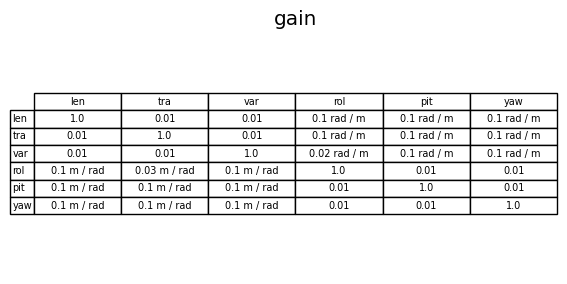

In [7]:
gain.plot_table('gain');

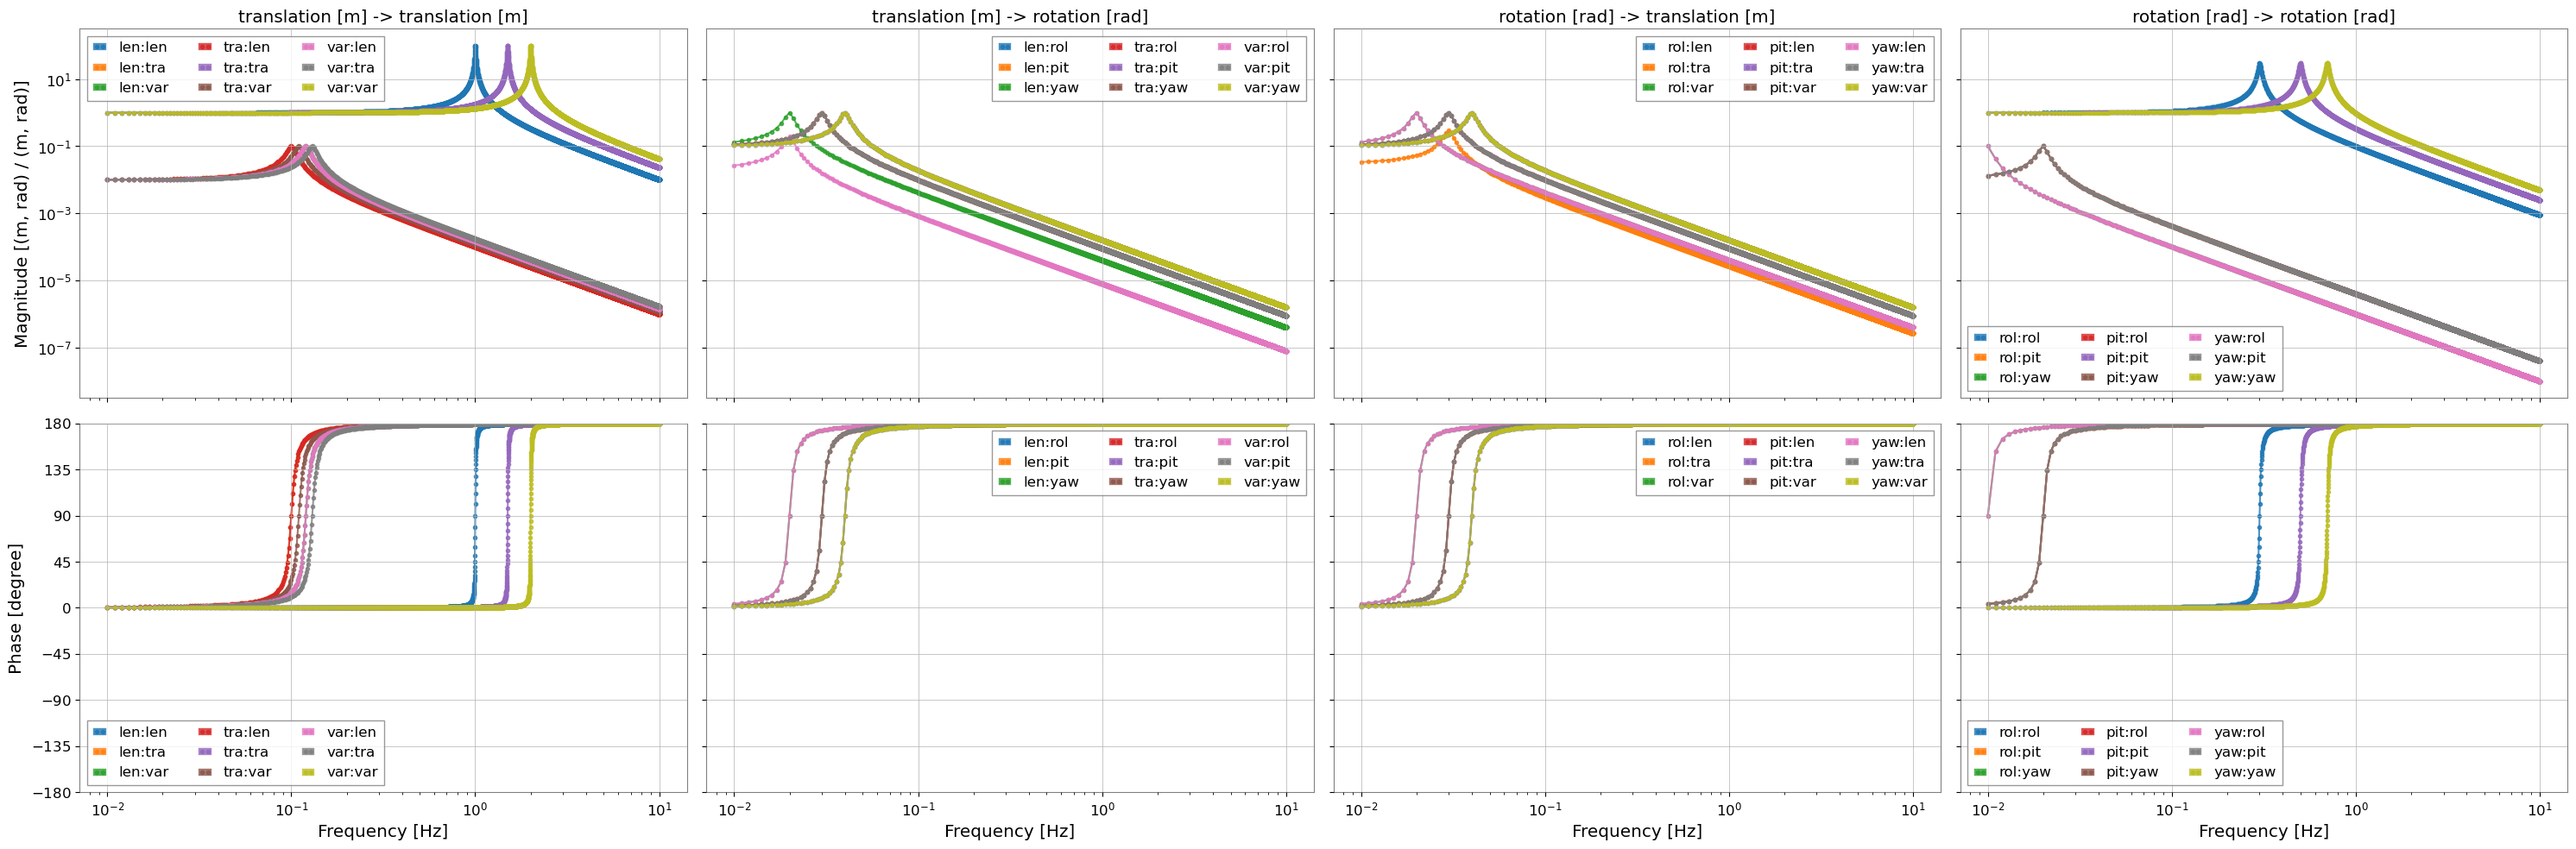

In [8]:
TF = TF_6x6(f_size=10000,df=0.001,f0=0.01)
f = TF.get_f()
dofs = TF.dofs

for dof1, dof2 in product(dofs, repeat=2):
    TF[dof1,dof2] = TF_resonant(f, f0[dof1,dof2], Q[dof1,dof2], gain[dof1,dof2])

TF.bodeplot();

In [11]:
{None}

{None}